In [15]:
#https://mgoulao.github.io/gym-docs/content/environment_creation/
# # Register the custom environment with Gym
# from gym.envs.registration import register

# register(
#     id='SingleLinkFlexibleJoint-v0',
#     entry_point='./Sys.Robot.Envs.Env:SingleLinkFlexibleJointEnv', 
# )

In [16]:
# System parameters 
M = 1 #kg
g = 9.81 
L = 1 #m
I = 0.5
J = 0.008
k = 0.3

In [17]:
# Define system ODE: dx/dt = f(x,u)
#x = [q1, q2, q1_dot, q2_dot]
import numpy as np

def sys_ode(x,u):

    dx_1 = x[0][2] 
    dx_2 = x[0][3]
    dx_3 = -M*g*L*np.sin(x[0][0])/I - k/I * (x[0][0]-x[0][1])
    dx_4 = -k/J * (x[0][1]-x[0][0]) + 1/J * u 
    dx = np.array([dx_1, dx_2, dx_3, dx_4]).reshape([1,-1])
    
    return dx

In [18]:
class Single_Link_Flexible_Joint:
    def __init__(self, dt = 0.001):
        self.Ac = -20*np.eye(4)
        self.dt = dt
        self.t = np.linspace(0, 10, int((10-0)/dt))
        self.xd = np.array([[.2*np.sin(4*np.pi*self.t/3)], [np.sin(4*np.pi*(self.t)/3)], [np.sin(4*np.pi*self.t/3)], [2*np.cos(4*np.pi*(self.t)/3)]]).T
        
    def reward(self):
        beta = 0.1
        sigma = 10
        return np.linalg.norm(self.x-self.xd)
        # return beta * np.exp(-(self.x-self.xd)**2/(2*sigma**2))
    def step(self, u):
        self.counter += 1
        self.x_dot = sys_ode(self.x, u[0])
        self.x += self.x_dot * self.dt
        info = {}
        truncated = False
        done = False
        if self.counter == 1000: #self.xd.shape[0] :
            done = True
        reward = self.reward()
        next_state = np.concatenate((self.x, self.xd[self.counter]),-1)
        return next_state, reward, done, truncated, info 
    def reset(self):
        self.counter = 0
        self.x = np.array([[.1],[.2],[.3],[.4]]).T
        return np.concatenate((self.x, self.xd[self.counter]),-1), 0

In [19]:
from RL.ActorCritic import ActorCriticAgent

# Create the environment
env = Single_Link_Flexible_Joint()

state_size = 4*2#env.observation_space.shape[0]
action_size = 1#env.action_space.shape[0]
action_max = .5#env.action_space.high

state_size, action_size, action_max


(8, 1, 0.5)

In [20]:
agent = ActorCriticAgent(state_size, action_size, hidden_dim=16, action_max=action_max)

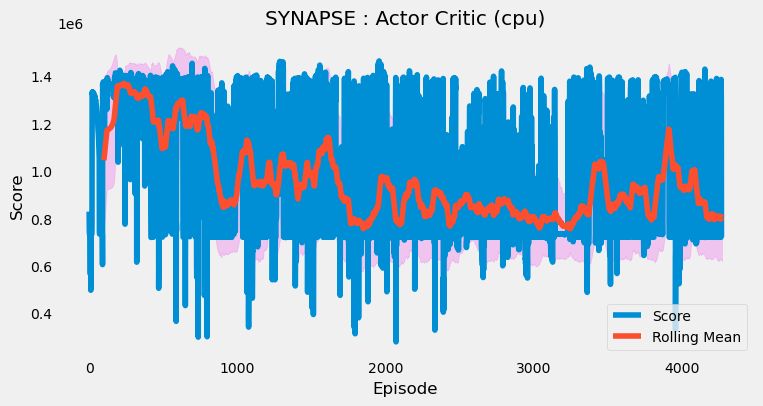

KeyboardInterrupt: 

In [21]:
result = agent.train(env, episodes=5000)